In [161]:
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.preprocessing.image import *
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [162]:
# data 형상 관련 상수
path='C:/Users/student/Downloads/데이터들/dogs-vs-cats'
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNEL=3

In [163]:
# 학습 데이터 준비하기
filenames=os.listdir(path+'/train')

In [164]:
len(filenames)

25000

In [165]:
categories=[]
for i in range(len(filenames)):
    if filenames[i].split('.')[0]=='cat':
        categories.append(0)
    else:
        categories.append(1)

In [166]:
df=pd.DataFrame({
'filename':filenames,
'category':categories})

In [113]:
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

ValueError: arrays must all be same length

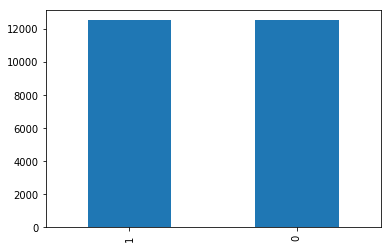

In [167]:
df['category'].value_counts().plot.bar()

cat.8371.jpg
C:/Users/student/Downloads/데이터들/dogs-vs-cats/train/cat.8371.jpg


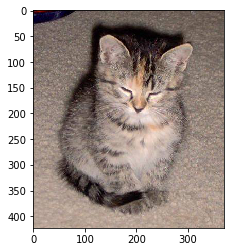

In [168]:
sample=random.choice(filenames)
print(sample)
print(path+'/train/'+sample)
image=load_img(path+'/train/'+sample,)
plt.imshow(image)

In [169]:
"""
배치정규화(batch normalization)
평균:0, 분산:1로 정규화를 해서 학습이 잘 이루어지도록 하는 것
fir(batch_size=32)

강아지-레이저1          - 레이어2         - 레이어3    - FC    - 분류
        (conv)           .........                      (Flatten)
        (BatchNorm)           .........                 (Dense)
        (Pool)           .........                      (BatchNorm)
        (DropOut)           .........                   (Dropout)
"""

'\n배치정규화(batch normalization)\n평균:0, 분산:1로 정규화를 해서 학습이 잘 이루어지도록 하는 것\nfir(batch_size=32)\n\n강아지-레이저1          - 레이어2         - 레이어3    - FC    - 분류\n        (conv)           .........                      (Flatten)\n        (BatchNorm)           .........                 (Dense)\n        (Pool)           .........                      (BatchNorm)\n        (DropOut)           .........                   (Dropout)\n'

In [170]:
from keras.models import Sequential
from keras.layers import *

In [171]:
model=Sequential()
model.add(Conv2D(32,(3,3), activation='relu', input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT, IMAGE_CHANNEL)))
model.add(BatchNormalization()) # 배치정규화
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [172]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)       

In [173]:
# reducelronplateau - loss가 더이상 개선되지 않으면 lr을 감소시켜라 => 저절로 lr을 조절해주는 역할
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [174]:
earlystop=EarlyStopping(patience=10)

In [175]:
learning_rate_reduction=ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    factor=0.5,
    min_lr=0.00001, # lr이 이 이하로 안떨어 지도록
    verbose=1 # msg가 화면에 잘 출력되도록
)

In [176]:
callbacks=[earlystop,learning_rate_reduction]

In [177]:
# 이미지 제너레이터에서 class_mode='categorical'로 지정하기 위해
# column 값을 string으로 변경
df['category']=df['category'].replace({0:'cat',1:'dog'})

In [178]:
train_df, validate_df=train_test_split(df, test_size=0.2, random_state=42)

In [179]:
train_df

,filename,category
23311,dog.8479.jpg,dog
23623,dog.876.jpg,dog
1020,cat.10915.jpg,cat
12645,dog.10127.jpg,dog
1533,cat.11377.jpg,cat
...,...,...
21575,dog.6916.jpg,dog
5390,cat.36.jpg,cat
860,cat.10771.jpg,cat
15795,dog.1713.jpg,dog


In [180]:
validate_df.shape

(5000, 2)

In [181]:
train_df=train_df.reset_index(drop=True)

In [182]:
validate_df=validate_df.reset_index(drop=True)

In [183]:
train_df['category']

0        dog
1        dog
2        cat
3        dog
4        cat
        ... 
19995    dog
19996    cat
19997    cat
19998    dog
19999    dog
Name: category, Length: 20000, dtype: object

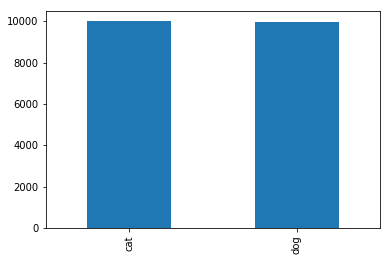

In [184]:
train_df['category'].value_counts().plot.bar()
validate_df['category'].value_counts().plot.bar()

In [185]:
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [186]:
# 트레이닝 데이터 제너레이터 설정

In [187]:
train_datagen=ImageDataGenerator(
    rotation_range=15,
    rescale=1./255.,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [188]:
train_generator=train_datagen.flow_from_dataframe(
    train_df,
    'C:/Users/student/Downloads/데이터들/dogs-vs-cats/train/',
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [214]:
validation_datagen=ImageDataGenerator(rescale=1./255.)
validation_generator=validation_datagen.flow_from_dataframe(
    validate_df,
    'C:/Users/student/Downloads/데이터들/dogs-vs-cats/train/',
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size

)

Found 5000 validated image filenames belonging to 2 classes.


In [215]:
example_df=train_df.sample(n=1).reset_index(drop=True)

In [216]:
example_df

,filename,category
0,cat.3715.jpg,cat


In [217]:
example_generator=train_datagen.flow_from_dataframe(
    example_df,
    'C:/Users/student/Downloads/데이터들/dogs-vs-cats/train/',
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


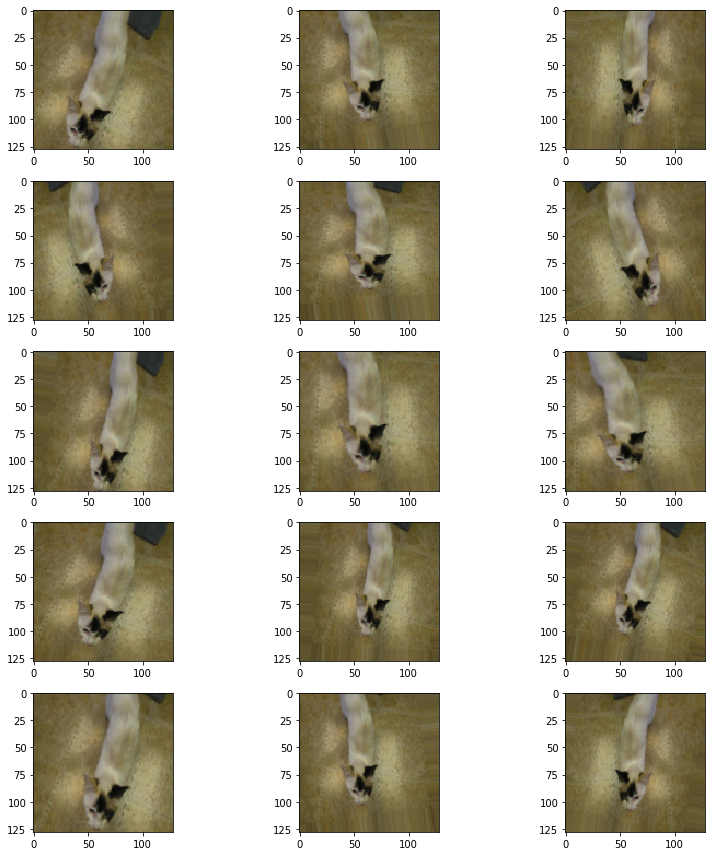

In [218]:
plt.figure(figsize=(12,12))
for i in range(0,15):
    plt.subplot(5,3,i+1)# (5,3,1) ........(5,3,15) 5줄에 3칸씩 총 15개 나옴
    for xBatch, yBatch in example_generator:
        image=xBatch[0]
        plt.imshow(image)
        break
    
plt.tight_layout()
plt.show()

In [221]:
FAST_RUN = True
epochs=3 if FAST_RUN else 50

In [223]:
history=model.fit_generator(
    train_generator,
    epochs=epochs,
    steps_per_epoch=total_train//batch_size,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    callbacks=callbacks    
)

Epoch 1/3
1333/1333 [==============================] - 957s 718ms/step - loss: 0.5809 - accuracy: 0.7057 - val_loss: 0.7498 - val_accuracy: 0.7257
Epoch 2/3
1333/1333 [==============================] - 936s 702ms/step - loss: 0.5244 - accuracy: 0.7437 - val_loss: 0.5179 - val_accuracy: 0.7673
Epoch 3/3
1333/1333 [==============================] - 946s 710ms/step - loss: 0.4789 - accuracy: 0.7731 - val_loss: 0.5374 - val_accuracy: 0.6696


In [224]:
model.save("model.h5")

In [226]:
# 1. traing, validation 에 대한 loss 출력 + 시각화
print(history.history['loss'])
print(history.history['val_loss'])
print(history.history['accuracy'])
print(history.history['val_accuracy'])

[0.5810133139319739, 0.5244512511046792, 0.47898152079139616]
[0.7497661709785461, 0.5179122686386108, 0.5374377965927124]
[0.70567924, 0.7437078, 0.7730798]
[0.7257257103919983, 0.7673019170761108, 0.6696088314056396]


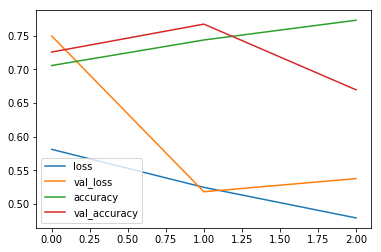

In [239]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
# 2. 테스트 
text1 폴더 안에 내용을 dataframe으로 구성
testdf='filename':테스트파일
nbsample=testdf.shape[0]

"""
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
    validate_df,
    'C:/Users/student/Downloads/데이터들/dogs-vs-cats/test1/',
    x_col='filename',
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=batch_size
    shuffle=False
)


3. 예측
predict=model.predict_generator(
    test_genrator, steps=nbsample/batch_size
)

4. argmax
np.argmax(predict, axis=?, )

5. kaggle 제출


"""

In [ ]:
import keras
fm=keras.datasets.fashion_mnist
(trainImage, trainLabel),(testImage, testLabel)=fm.load_data()
# 레이블 : 0~9()
# keras.io -> 검색어 : fashin_mnist
# 테스트 데이터로 테스트 정확도 출력